<a name="1"></a>
## Import the Libraries

In [90]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords_english

from tensorflow.keras import losses
import re
import string
import matplotlib.pyplot as plt
import nltk

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, twitter_samples, wordnet
from nltk.stem import WordNetLemmatizer

print("Imports successful!")

Imports successful!


In [56]:
nltk.download('twitter_samples')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [57]:
stopwords_english = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

<a name="2"></a>
## 2 - Import the Data

<a name="2-1"></a>
### 2.1 - Load and split the Data

- Import the positive and negative tweets
- Have a look at some examples of the tweets
- Split the data into the training and validation sets
- Create labels for the data

In [58]:
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

In [59]:
print(f"The number of positive tweets: {len(all_positive_tweets)}")
print(f"The number of negative tweets: {len(all_negative_tweets)}")

The number of positive tweets: 5000
The number of negative tweets: 5000


In [60]:
tweet_number = 4
print('Positive tweet example:')
print(all_positive_tweets[tweet_number])
print('\nNegative tweet example:')
print(all_negative_tweets[tweet_number])

Positive tweet example:
yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days

Negative tweet example:
Dang starting next week I have "work" :(


Here you will process the tweets. This part of the code has been implemented for you.  The processing includes:

- tokenizing the sentence (splitting to words)
- removing stock market tickers like $GE
- removing old style retweet text "RT"
- removing hyperlinks
- removing hashtags
- lowercasing
- removing stopwords and punctuation
- stemming

Some of these things are general steps you would do when processing any text, some others are very "tweet-specific". The details of the process_tweet function are available in utils.py file

In [65]:
nlp = spacy.load("en_core_web_sm")

def preprocess(tweet):
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'#', '', tweet)

    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    doc = nlp(" ".join(tweet_tokens))
    tweet_clean = []

    for token in doc:
        if token.text not in stopwords_english and token.text not in string.punctuation:
            tweet_clean.append(token.lemma_)

    return tweet_clean

In [66]:
all_positive_tweets_processed = [preprocess(tweet) for tweet in all_positive_tweets]
all_negative_tweets_processed = [preprocess(tweet) for tweet in all_negative_tweets]

In [67]:
val_pos = all_positive_tweets_processed[4000:]
train_pos = all_positive_tweets_processed[:4000]

val_neg = all_negative_tweets_processed[4000:]
train_neg = all_negative_tweets_processed[:4000]

train_x = train_pos + train_neg
val_x = val_pos + val_neg

train_y = [[1] for _ in train_pos] + [[0] for _ in train_neg]
val_y  = [[1] for _ in val_pos] + [[0] for _ in val_neg]

In [68]:
print(f"There are {len(train_x)} sentences for training.")
print(f"There are {len(train_y)} labels for training.\n")
print(f"There are {len(val_x)} sentences for validation.")
print(f"There are {len(val_y)} labels for validation.")

There are 8000 sentences for training.
There are 8000 labels for training.

There are 2000 sentences for validation.
There are 2000 labels for validation.


In [70]:
all_tweets = train_x + val_x

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_tweets)

train_seq = tokenizer.texts_to_sequences(train_x)
val_seq = tokenizer.texts_to_sequences(val_x)

In [115]:
def build_vocabulary(corpus):
    vocab = {'': 0, '[UNK]': 1}

    for tweet in corpus:
        for word in tweet:
            if word not in vocab:
                vocab[word] = len(vocab)
    return vocab


vocab = build_vocabulary(train_x)
num_words = len(vocab)

print(f"Vocabulary contains {num_words} words\n")
print(vocab)

Vocabulary contains 9150 words

{'': 0, '[UNK]': 1, 'followfriday': 2, 'engage': 3, 'member': 4, 'community': 5, 'week': 6, ':)': 7, 'hey': 8, 'james': 9, 'odd': 10, ':/': 11, 'contact': 12, 'centre': 13, '02392441234': 14, 'able': 15, 'assist': 16, 'thank': 17, 'listen': 18, 'night': 19, 'bleed': 20, 'amazing': 21, 'track': 22, 'scotland': 23, 'congrat': 24, 'yeaaah': 25, 'yipppy': 26, 'accnt': 27, 'verify': 28, 'rqst': 29, 'succeed': 30, 'get': 31, 'blue': 32, 'tick': 33, 'mark': 34, 'fb': 35, 'profile': 36, '15': 37, 'day': 38, 'irresistible': 39, 'flipkartfashionfriday': 40, 'like': 41, 'lovely': 42, 'customer': 43, 'wait': 44, 'long': 45, 'hope': 46, 'enjoy': 47, 'happy': 48, 'friday': 49, 'lwwf': 50, 'second': 51, 'thought': 52, "'": 53, 's': 54, 'time': 55, 'dd': 56, 'new': 57, 'short': 58, 'enter': 59, 'system': 60, 'sheep': 61, 'buy': 62, 'jgh': 63, 'bayan': 64, ':D': 65, 'bye': 66, 'act': 67, 'mischievousness': 68, 'call': 69, 'etl': 70, 'layer': 71, 'house': 72, 'warehousing

In [76]:
max_seq_length = max(len(seq) for seq in train_seq)
train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_seq, maxlen=max_seq_length, padding='post')
val_padded = tf.keras.preprocessing.sequence.pad_sequences(val_seq, maxlen=max_seq_length, padding='post')

In [79]:
train_y = np.array(train_y)
val_y = np.array(val_y)

In [106]:
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 10549


In [102]:
word_index = tokenizer.word_index
vocab = list(word_index.keys())

print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 10548


In [103]:
word_to_index = {word: idx for word, idx in word_index.items()}

index_to_word = {idx: word for word, idx in word_index.items()}

if '<UNK>' not in word_to_index:
    vocab.append('<UNK>')
    word_to_index['<UNK>'] = len(word_to_index) + 1
    index_to_word[len(index_to_word) + 1] = '<UNK>'

print(f"Word to index mapping (sample): {list(word_to_index.items())[:10]}")
print(f"Index to word mapping (sample): {list(index_to_word.items())[:10]}")

Word to index mapping (sample): [(':(', 1), (':)', 2), ('thank', 3), (':-)', 4), (':d', 5), ('...', 6), ('follow', 7), (':-(', 8), ('love', 9), ('like', 10)]
Index to word mapping (sample): [(1, ':('), (2, ':)'), (3, 'thank'), (4, ':-)'), (5, ':d'), (6, '...'), (7, 'follow'), (8, ':-('), (9, 'love'), (10, 'like')]


In [ ]:
if '<UNK>' not in vocab:
    vocab.append('<UNK>')

word_to_index = {word: i for i, word in enumerate(vocab)}
index_to_word = {i: word for i, word in enumerate(vocab)}

In [83]:
def create_model(num_words, embedding_dim, max_len):
    tf.random.set_seed(123)

    model = tf.keras.Sequential([

        tf.keras.layers.Embedding(input_dim=num_words,
                                  output_dim=embedding_dim,
                                  input_shape=(max_len,)),  # Specify input shape explicitly

        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


In [84]:
model = create_model(num_words=len(vocab)+1, embedding_dim=16, max_len=max_seq_length)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 51, 16)              │         168,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_5           │ (None, 16)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168,801 (659.38 KB)

 Trainable params: 168,801 (659.38 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
train_x_prepared = np.array(train_padded)
train_y_prepared = np.array(train_y)

val_x_prepared = np.array(val_padded)
val_y_prepared = np.array(val_y)

In [86]:
history = model.fit(train_x_prepared, train_y_prepared, epochs=20, validation_data=(val_x_prepared, val_y_prepared))

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5938 - loss: 0.6801 - val_accuracy: 0.9650 - val_loss: 0.6093
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9251 - loss: 0.5665 - val_accuracy: 0.9940 - val_loss: 0.4363
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9842 - loss: 0.3870 - val_accuracy: 0.9970 - val_loss: 0.2804
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9910 - loss: 0.2447 - val_accuracy: 0.9960 - val_loss: 0.1820
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9942 - loss: 0.1592 - val_accuracy: 0.9965 - val_loss: 0.1248
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9948 - loss: 0.1102 - val_accuracy: 0.9965 - val_loss: 0.0905
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9952 - loss: 0.0809 - val_accuracy: 0.9955 - val_loss: 0.0687
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9956 - loss: 0.0622 - val_accuracy: 0.

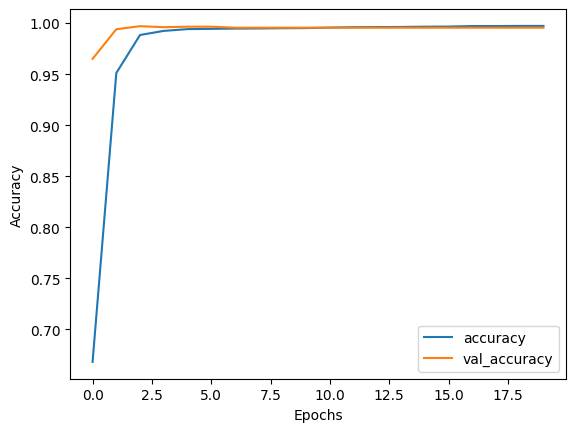

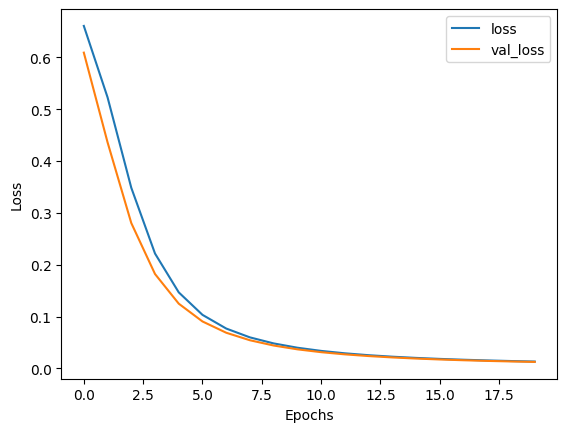

In [87]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric.title())
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

In [112]:
embedding_layer = model.layers[0]
embeddings = embedding_layer.get_weights()[0]
print(f"Weights of embedding layer have shape: {embeddings.shape}")

Weights of embedding layer have shape: (10549, 16)


In [113]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

embeddings_2D = pca.fit_transform(embeddings)

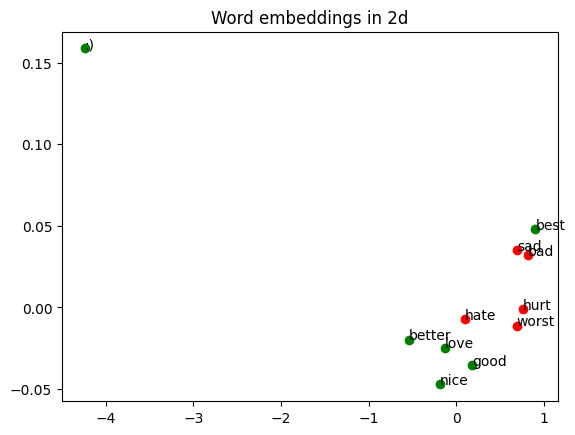

In [116]:
#Selection of negative and positive words
neg_words = ['bad', 'hurt', 'sad', 'hate', 'worst']
pos_words = ['best', 'good', 'nice', 'love', 'better', ':)']

#Index of each selected word
neg_n = [vocab[w] for w in neg_words]
pos_n = [vocab[w] for w in pos_words]

plt.figure()

#Scatter plot for negative words
plt.scatter(embeddings_2D[neg_n][:,0], embeddings_2D[neg_n][:,1], color = 'r')
for i, txt in enumerate(neg_words):
    plt.annotate(txt, (embeddings_2D[neg_n][i,0], embeddings_2D[neg_n][i,1]))

#Scatter plot for positive words
plt.scatter(embeddings_2D[pos_n][:,0], embeddings_2D[pos_n][:,1], color = 'g')
for i, txt in enumerate(pos_words):
    plt.annotate(txt,(embeddings_2D[pos_n][i,0], embeddings_2D[pos_n][i,1]))

plt.title('Word embeddings in 2d')

plt.show()